In [1]:
import k2
import torch

/k2-dev/yangyifan/anaconda3/envs/icefall/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


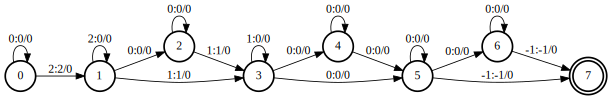

In [2]:
decoding_graph = k2.ctc_graph([[2,1,0]], modified=False)
k2.to_dot(decoding_graph[0])

In [3]:
LogSoftmax = torch.nn.LogSoftmax(dim=2)
nnet_output = LogSoftmax(torch.tensor([[[1.,2.,10.], [2.,10.,3.], [10.,2.,1.]]]))

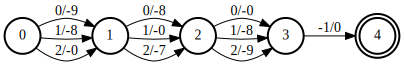

In [4]:
supervision_segments = torch.tensor([[0, 0, 3]]).to(torch.int32)
dense_fsa_vec = k2.DenseFsaVec(
    nnet_output,
    supervision_segments,
    allow_truncate=1,
)
fsa = k2.convert_dense_to_fsa_vec(dense_fsa_vec)
k2.to_dot(fsa[0])

In [5]:
k2.ctc_loss(
    decoding_graph=decoding_graph,
    dense_fsa_vec=dense_fsa_vec,
    output_beam=10,
    reduction='sum',
    use_double_scores=True,
)

tensor(0.0022)

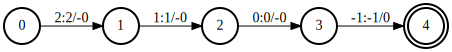

In [6]:
lattice_fake = k2.intersect(
    k2.arc_sort(decoding_graph[0]),
    k2.arc_sort(fsa[0]),
    treat_epsilons_specially=False,
)
lattice_fake = k2.connect(lattice_fake)
lattice = k2.intersect_dense(
    a_fsas=decoding_graph,
    b_fsas=dense_fsa_vec,
    output_beam=1,
    frame_idx_name=None,
)
k2.to_dot(lattice_fake)

In [7]:
tot_scores = lattice.get_tot_scores(
    log_semiring=True, use_double_scores=True
)

In [8]:
loss = -1 * tot_scores
loss

tensor([0.0022], dtype=torch.float64)

In [9]:
loss.sum()

tensor(0.0022, dtype=torch.float64)